### Setting up the GEE Packages

In [ ]:
#pip install earthengine-api --upgrade

import subprocess
try:
  import geemap
except ImportError:
  print('geemap package not installed. Installing ...')
  subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])
  import geemap
import ee
try:
  ee.Initialize()
except Exception as e:
  ee.Authenticate()
  ee.Initialize()

Map = geemap.Map()

geemap package not installed. Installing ...
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=56JIc7Wq0PW7gwM3vxuoN92WmWLhVt1YSUVN6pL4PJU&tc=jxxA346Iuze-gx5T-4MLoNlc3P9j1pDMLNm7NUCT9HQ&cc=qCLRUVyeurwpvrbVp4zCLql6r47JM5sG0XepJbFCIWs

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BVAQKpC52ntWEJjF5G-7k0M8pnpjQ4Dhkxa6jf-SrQ7x9SVGuN15wA

Successfully saved authorization token.


###Import Your SAR Probability Raster (produced from Script 2)

In [ ]:
#### Change these ##########
res_name = 'ArnPrior'
GEE_Asset_Directory = 'projects/ee-climatechangehydrology/assets/reservoirs_s1c_tiff/'
############################

SAR_WaterProbability =ee.Image(str(GEE_Asset_Directory)+str(res_name)+'_s1c')
#SAR_WaterProbability =ee.Image('projects/ee-karloslao/assets/SAR_RawProbabilityMap')

### Create a Histogram to Get Data Disbribution of the Image




In [ ]:
import numpy as np
# Do a natural breaks classification with three classes (non-water,seasonal water, permanent water)
histogram = SAR_WaterProbability.reduceRegion(reducer=ee.Reducer.histogram(),geometry=SAR_WaterProbability.geometry(),scale=10)

# Extract the histogram values
histogram_values = histogram.get('classification')  #Change the band name if needed
# Convert histogram values to a list
histogram_dict = ee.Dictionary(histogram_values)
#Extract the "buketMeans" from the dictionary
means_arrays = histogram_dict.get('bucketMeans')
#Convert the array into a python list and then a numpy array
np_array = np.array(means_arrays.getInfo())

#Get the break values for the 3 classes
values_array = np.histogram(np_array, bins=3)[1]
values_array

array([0.00148595, 0.33320183, 0.66491771, 0.99663359])

### Show Histogram

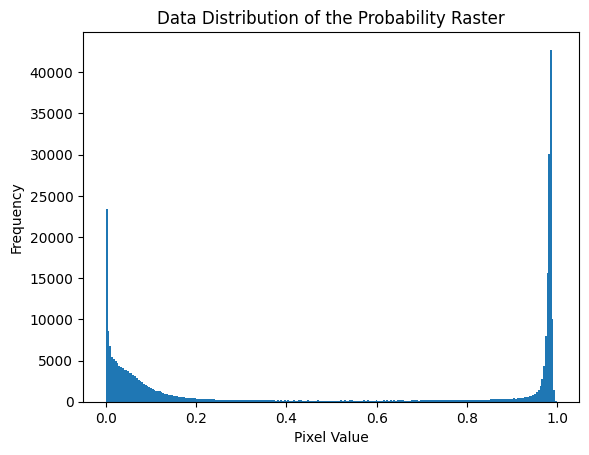

In [ ]:
import matplotlib.pyplot as plt

# Convert histogram values to a Python list
histogram_list = histogram_values.getInfo()

# Extract the bucket boundaries and counts
bucket_boundaries = histogram_list['bucketMeans']
bucket_counts = histogram_list['histogram']

# Plot the histogram
plt.bar(bucket_boundaries, bucket_counts, width=np.diff(bucket_boundaries)[0])
plt.title('Data Distribution of the Probability Raster')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

### Get Max and Min Water Polygons by a 3-class Natural Breaks Classification (maybe set hard breaks Land 0.1, Shallow 0.1-0.6, Water >0.6)

In [ ]:
# Reclassify the probability map with the break values
# Non-water = <=array[1]
# seasonal water >array[1] but <=array [2]
# Permanent water > array [2] but <=array[3]

max_water = SAR_WaterProbability.gt(values_array[1]).selfMask()
min_water = SAR_WaterProbability.gt(values_array[2]).selfMask()

#Convert the images to polygons (raster -> vectors)
max_water_poly = max_water.reduceToVectors(geometryType='polygon', geometry = max_water.geometry(),scale=10, eightConnected=False, labelProperty='classification',bestEffort=True)
min_water_poly = min_water.reduceToVectors(geometryType='polygon', geometry = min_water.geometry(),scale=10, eightConnected=False, labelProperty='classification',bestEffort=True)

### Quick Visualization (only run this if absolutely necessary)

In [ ]:
# Calling the map function will consumes a lot of memory to run the previously submitted operations on GEE's server

#Map.addLayer(max_water_poly, {},'max_water_poly')
#Map.addLayer(min_water_poly, {},'min_water_poly')
#Map.centerObject(SAR_WaterProbability, zoom = 13)
#Map

In [ ]:
## Future works:
## Get the largest polygon (remove non-reservoir water bodies)
## Get the name of the reservoir from GRes points (spatial join)

### Export the Polygons to Google Drive

In [ ]:
# What's the Name of the reservoir?
res_name = 'ArnPrior'

# Name of the folder you want to export to on Google Drive (a new one will be created if none exists)
FolderName = 'Min_Max_WaterPolygons'

### Export the Max Water Polygon (as shapefiles)
Export_MaxWater_Polys = ee.batch.Export.table.toDrive(collection=max_water_poly, folder=FolderName , description=str(res_name )+'_Max', fileFormat='SHP')
#Export_MaxWater_Polys.start()

### Export the Min Water Polygon (as shapefiles)
Export_MinWater_Polys = ee.batch.Export.table.toDrive(collection=min_water_poly, folder=FolderName , description=str(res_name )+'_Min', fileFormat='SHP')
#Export_MinWater_Polys.start()